In [3]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
from utils_model_sampling import sample_models_across_time

In [5]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [6]:
# Is it possible that it has memory issues?

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order()) # Should you run things locally?

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_3.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_3.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adul

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_BERT_without_tags,_,_+-20_utts_context/run_models_across_time_1.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_3.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_1.0.csv
/home/nwong/chompsky/childes/child_l

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Flat_prior_without_tags,_,_same_utt_only/run_models_across_time_4.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Flat_prior_without_tags,_,_same_utt_only/run_models_across_time_1.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_3.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_defau

In [7]:
raw_scores_across_time['model'].shape

(248116,)

In [8]:
set(raw_scores_across_time['model'])

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [92]:
# From the original analysis
original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}


is_filter = True
if is_filter:
    # I think if you don't copy R will get the slice and still try to compute over all models
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)].copy()
else:
    scores_across_time = raw_scores_across_time

In [93]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [94]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [95]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

          model prior_surprisal
1   CDL+Context        3.405310
2    CDL+OneUtt        5.032847
3  BERT+Context        4.728340
4   BERT+OneUtt        7.176585
5 CHILDES 1gram        8.772759
6  UniformPrior       12.948367


In [96]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id  CDL+Context   CDL+OneUtt BERT+Context  BERT+OneUtt
1           170 0.0135520743 3.438002e-04 3.539034e-04 3.337238e-06
2           743 0.9261437058 4.461595e-05 2.658662e-04 1.553577e-06
3          1303          NaN          NaN          NaN          NaN
4          1529 0.0012822745 7.239137e-03 2.260151e-04 2.206537e-04
5          3118 0.9854978323 3.438002e-04 5.423141e-01 3.337238e-06
6         10011 0.0004756536 2.709485e-03 2.849880e-06 6.667631e-06
  CHILDES 1gram UniformPrior
1  3.489544e-04 0.0001265182
2  4.338794e-05 0.0001265182
3           NaN          NaN
4  3.763246e-03 0.0001265182
5  3.489544e-04 0.0001265182
6  3.399313e-03 0.0001265182


In [97]:
%%R
model_names = unique(successes_across_time$model)
print(model_names) # Probably because it's not a copy?

# It's still 18 levels -- why?

[1] BERT+OneUtt   BERT+Context  CDL+OneUtt    CDL+Context   UniformPrior 
[6] CHILDES 1gram
18 Levels: CDL+Context+Tags CDL+Context CDL+OneUtt+Tags ... UniformPrior


In [98]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in .subset2(x, i, exact = exact) : subscript out of bounds




Error in .subset2(x, i, exact = exact) : subscript out of bounds


In [103]:
%%R
print(successes_across_time_wide[[comparison_model_name]])

    [1] 3.489544e-04 4.338794e-05          NaN 3.763246e-03 3.489544e-04
    [6] 3.399313e-03 8.710675e-03 1.221330e-02 1.095576e-04 3.399313e-03
   [11] 3.399313e-03          NaN 2.532612e-02 4.027612e-03 3.489544e-04
   [16] 2.532612e-02 3.489544e-04 9.745356e-03 1.812893e-02 4.213664e-04
   [21] 4.756755e-04 2.520692e-03 1.286813e-02 4.027612e-03 1.426084e-03
   [26] 1.286813e-02 1.460729e-03 3.281266e-02 1.133314e-03 1.460729e-03
   [31] 1.460729e-03 1.460729e-03 1.460729e-03 1.460729e-03 1.460729e-03
   [36] 1.460729e-03 1.460729e-03 1.460729e-03 1.460729e-03 3.399313e-03
   [41] 1.648626e-03 1.812893e-02 2.144302e-04 1.607426e-03 2.144302e-04
   [46] 1.648626e-03 2.780436e-02 1.203229e-03 8.951660e-04 1.286813e-02
   [51] 4.027612e-03 9.745356e-03 8.710675e-03 2.189029e-02 3.211756e-04
   [56] 3.281266e-02 4.027612e-03 1.812893e-02 8.302730e-05 1.286813e-02
   [61] 3.399313e-03 1.133314e-03 1.245394e-04 2.189029e-02 4.027612e-03
   [66] 1.426084e-03 2.532612e-02 2.532612e-02 3.39

  [561] 3.741397e-03 1.426084e-03 1.286813e-02 3.958945e-03 1.068827e-02
  [566] 6.149095e-05 5.933420e-06 3.281266e-02 1.286813e-02 4.375967e-04
  [571] 2.230292e-02 3.399313e-03 3.958945e-03 2.075636e-04 3.341258e-03
  [576] 6.192483e-03 3.945240e-04 1.966393e-04 1.966393e-04 1.966393e-04
  [581] 1.966393e-04 5.764905e-04 3.991406e-03 1.835302e-04 1.873038e-05
  [586] 2.532612e-02 3.399313e-03 1.376485e-04 3.489544e-04 2.145835e-03
  [591] 1.812893e-02 1.221957e-03 2.532612e-02 1.159533e-03 7.329852e-03
  [596] 5.416862e-03 2.513448e-02 1.373644e-05 2.513448e-02 1.351515e-04
  [601] 2.780436e-02 3.408392e-04 2.532612e-02 1.282848e-04 9.529084e-04
  [606] 1.221330e-02 9.572781e-04 2.805971e-03 6.149095e-05 3.399313e-03
  [611] 5.559814e-03 3.860968e-04 5.679668e-03 3.281266e-02 1.022228e-02
  [616] 1.215836e-02 1.607426e-03 5.559814e-03 2.671759e-03 1.481170e-02
  [621] 6.356971e-03 4.213446e-02 5.416862e-03 2.513448e-02 3.281266e-02
  [626] 1.426084e-03 4.047900e-03 5.431217e-05 1.48

 [1121] 3.399313e-03 9.397993e-04 5.003330e-04 9.397993e-04 5.003330e-04
 [1126] 1.812893e-02 3.281266e-02 3.281266e-02 1.221330e-02 3.402150e-04
 [1131] 4.453997e-04 1.703247e-03 1.248796e-05 1.215836e-02 3.946773e-03
 [1136] 2.230292e-02 7.325510e-04 1.079252e-02 2.507583e-03 1.481170e-02
 [1141] 2.780436e-02 8.951660e-04 1.607426e-03 1.133030e-04 4.453997e-04
 [1146] 1.812893e-02 1.286813e-02 4.741149e-04 2.532612e-02 2.532612e-02
 [1151] 2.532612e-02 6.052057e-04 6.052057e-04 1.975729e-03 9.638327e-04
 [1156] 1.481170e-02 3.249210e-04 1.607426e-03 2.230292e-02 6.425325e-03
 [1161] 1.481170e-02 1.022228e-02 1.022228e-02 1.022228e-02 4.213664e-04
 [1166] 2.805971e-03 1.122543e-02 3.399313e-03 8.710675e-03 4.525785e-04
 [1171] 2.070301e-03 1.385848e-04 6.738723e-04 4.975239e-04 4.756755e-04
 [1176] 1.013148e-03 7.329852e-03 2.570254e-02 4.859755e-04 1.829060e-04
 [1181] 2.884029e-04 3.238258e-03 1.975729e-03 9.638327e-04 1.481170e-02
 [1186] 1.286813e-02 4.213446e-02 8.710675e-03 1.48

 [1681] 1.716697e-04 1.560917e-05 1.560917e-05 1.342432e-05 7.028995e-04
 [1686] 2.513448e-02 1.560917e-05 7.968763e-03 2.513448e-02 6.885420e-04
 [1691] 2.987029e-04 1.607426e-03 7.740912e-05 3.763246e-03 1.022228e-02
 [1696] 7.740912e-05 7.116670e-05 4.997088e-04 1.835302e-04 5.712126e-05
 [1701] 5.712126e-05 1.835302e-04 3.342847e-04 4.997088e-04 4.213446e-02
 [1706] 5.622238e-03 2.780436e-02 4.027612e-03 2.303484e-04 3.281266e-02
 [1711] 2.570254e-02 3.801665e-04 1.082439e-03 5.093845e-04 8.177881e-05
 [1716] 1.082439e-03 8.646063e-05 2.743574e-04 1.250794e-02 3.168059e-04
 [1721] 1.545030e-04 3.542604e-04 1.423303e-04 7.397579e-05          NaN
 [1726] 1.538788e-04 5.271726e-03 3.168059e-04 3.898422e-04 3.399313e-03
 [1731] 1.082439e-03 1.082439e-03 1.560917e-05 1.560917e-05 8.389843e-04
 [1736] 3.340006e-05 2.513448e-02 3.340006e-05 2.513448e-02 1.101818e-04
 [1741] 2.002259e-03 2.532612e-02 2.060310e-05 5.181520e-05 1.305293e-03
 [1746] 3.281266e-02 2.532612e-02          NaN     

 [2241] 3.281266e-02 3.639362e-04 1.481170e-02 6.059832e-03 1.481170e-02
 [2246] 1.560917e-05 6.426886e-03 3.399313e-03 3.399313e-03 1.061523e-05
 [2251]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3.803509e-03 1.743511e-03 1.120830e-03
 [2761] 1.148636e-04 2.513448e-02 1.182970e-04 1.853690e-03 1.812893e-02
 [2766] 1.238499e-03 8.951660e-04          NaN 2.532612e-02 2.189029e-02
 [2771] 5.719932e-03 2.622128e-05 3.281266e-02 7.179094e-05 2.570254e-02
 [2776] 1.950787e-04 6.192483e-03 7.275571e-04 3.803509e-03 6.273631e-07
 [2781] 3.803509e-03 3.589703e-05 1.079252e-02 8.480358e-04 2.189029e-02
 [2786] 5.462429e-05 3.933036e-05 4.213446e-02 6.425325e-03 1.286813e-02
 [2791] 2.543817e-04 3.015120e-04 2.300363e-04          NaN 1.286813e-02
 [2796] 2.189029e-02 5.764905e-04 2.513448e-02 1.388970e-04 3.945240e-04
 [2801] 3.008877e-04 1.481170e-02 2.417380e-03 4.213446e-02 2.388977e-03
 [2806] 2.513448e-02 2.570254e-02 1.022228e-02 2.513448e-02 5.836974e-05
 [2811] 3.945240e-04 3.945240e-04 6.426886e-03 5.282026e-03 8.710675e-03
 [2816] 2.189029e-02 3.281266e-02 1.022228e-02 2.532612e-02 3.399313e-03
 [2821] 2.532612e-02 3.464855e-05 1.122543e-02 1.079252e-02 2.070301e-03
 [2826] 3.8

 [3316] 3.395907e-04 1.001128e-02 2.780436e-02 2.341219e-05 3.281266e-02
 [3321] 1.426084e-03 3.998301e-04 2.189029e-02 2.513448e-02 1.248487e-03
 [3326] 2.570254e-02 4.213446e-02 1.509420e-03 1.987277e-03 1.481170e-02
 [3331] 2.570254e-02 3.238258e-03 3.133385e-03 8.190994e-03 3.650882e-03
 [3336] 3.781036e-03 1.001128e-02 6.155057e-04 2.189029e-02 2.570254e-02
 [3341] 6.356971e-03 2.230292e-02 2.570254e-02 5.306369e-05 6.426886e-03
 [3346] 3.470816e-04 7.329852e-03 2.189029e-02 1.079252e-02 5.712126e-05
 [3351] 4.756755e-04 4.027612e-03 2.189029e-02 3.281266e-02 9.925759e-05
 [3356] 2.513448e-02 1.480393e-03 3.652127e-05 3.300682e-03 9.572781e-04
 [3361] 2.189029e-02 1.460729e-03 2.570254e-02 4.027612e-03 2.189029e-02
 [3366] 3.281266e-02 9.925759e-05 4.213446e-02 2.388977e-03 4.213446e-02
 [3371] 2.388977e-03 2.532612e-02 2.145835e-03 2.570254e-02 2.570254e-02
 [3376] 2.189029e-02 5.559814e-03 2.249147e-03 1.220424e-04 1.001128e-02
 [3381] 8.710675e-03 5.265512e-04 3.281266e-02 1.96

 [3876] 2.189029e-02 1.215836e-02 3.650882e-03 2.815362e-04 4.213446e-02
 [3881] 1.509420e-03 5.146906e-04 3.202676e-03 5.416862e-03 3.281266e-02
 [3886] 1.232909e-04 2.189029e-02 3.296029e-04 2.780436e-02 1.222893e-03
 [3891] 1.148636e-04 9.745356e-03 1.068827e-02 8.190994e-03 1.394247e-03
 [3896] 2.189029e-02 7.384813e-04 2.230292e-02 6.356971e-03 1.853690e-03
 [3901] 2.513448e-02 2.417380e-03 3.300682e-03 2.780436e-02 9.488789e-05
 [3906] 1.221330e-02 3.407740e-03 3.817555e-03 3.340006e-05 2.230292e-02
 [3911] 5.146906e-04 5.705602e-04 1.169208e-03 6.454693e-04 5.719932e-03
 [3916] 2.570254e-02 2.002259e-03 3.741397e-03 3.741397e-03 3.741397e-03
 [3921] 3.741397e-03 1.832181e-04 4.213446e-02 6.425325e-03 2.780436e-02
 [3926] 2.780436e-02 5.719932e-03 2.780436e-02 5.719932e-03 2.780436e-02
 [3931] 3.763246e-03 2.780436e-02 2.780436e-02 5.719932e-03 6.155057e-04
 [3936] 1.286813e-02 9.745356e-03 3.202676e-03 8.710675e-03 1.691727e-04
 [3941]          NaN 1.122543e-02 1.481170e-02 2.94

 [4436] 3.741397e-03 1.395212e-04 3.015120e-04 6.192483e-03 2.780436e-02
 [4441] 1.286813e-02 2.543817e-04 5.559814e-03 2.671759e-03 1.812893e-02
 [4446] 5.559814e-03 2.671759e-03 1.812893e-02 2.584393e-04 3.273216e-03
 [4451] 6.426886e-03 4.213446e-02 2.805971e-03 6.426886e-03 4.213446e-02
 [4456] 2.805971e-03 6.426886e-03 4.213446e-02 2.805971e-03 8.710675e-03
 [4461] 8.389843e-04 1.812893e-02 1.289063e-03 4.213446e-02 5.416862e-03
 [4466] 7.394177e-04          NaN 1.289063e-03 1.079252e-02 2.934249e-05
 [4471] 2.599999e-04 3.273216e-03 9.745356e-03 5.719932e-03 5.549542e-04
 [4476] 4.213446e-02 1.699814e-03 1.169208e-03 1.001128e-02 9.020608e-05
 [4481] 1.481170e-02 5.271726e-03 1.221330e-02 1.975729e-03 9.638327e-04
 [4486] 1.812893e-02 8.870509e-04 2.249147e-03 5.719932e-03 3.763246e-03
 [4491] 3.763246e-03 1.221330e-02 2.249147e-03 3.281266e-02 3.399313e-03
 [4496] 2.189029e-02 3.979574e-04 5.559814e-03 6.059832e-03 9.572781e-04
 [4501] 8.611449e-04 2.403644e-05 8.710675e-03 8.38

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 [5401] 5.679668e-03 2.780436e-02 2.417380e-03 1.079252e-02 4.407179e-04
 [5406] 9.745356e-03 5.559814e-03 3.273216e-03 3.741397e-03 1.426084e-03
 [5411] 6.648489e-05 6.192483e-03 3.177395e-03 1.286813e-02 2.727968e-04
 [5416] 3.341258e-03 1.022228e-02 9.745356e-03 1.068827e-02 2.513448e-02
 [5421] 4.213446e-02 6.425325e-03 1.305293e-03 3.399313e-03 1.052163e-03
 [5426] 4.213446e-02 6.425325e-03 1.481170e-02 1.481170e-02 1.068827e-02
 [5431] 3.837842e-03 5.712126e-05 4.213446e-02 4.267633e-03 2.293156e-03
 [5436] 5.836974e-05 5.864784e-04 1.221330e-02 1.251605e-06 8.274358e-04
 [5441] 1.215836e-02 3.633119e-04 4.613179e-04 1.001128e-02 2.230292e-02
 [5446] 3.633119e-04 4.613179e-04 1.128320e-03 5.933420e-06 4.213446e-02
 [5451] 5.380997e-04 3.879695e-04 1.928939e-04 2.189029e-02 3.879695e-04
 [5456] 1.142394e-04 1.648030e-04 1.221330e-02 2.532612e-02 1.661111e-03
 [5461] 3.281266e-02 2.273804e-03 1.703247e-03 1.703247e-03 2.189029e-02
 [5466] 1.703247e-03 3.958945e-03 3.946773e-03 4.0

 [5961] 2.532612e-02 3.763246e-03 5.719932e-03          NaN 1.286813e-02
 [5966] 1.286813e-02 4.027612e-03 1.743511e-03 2.277862e-03 1.142394e-04
 [5971] 1.238499e-03 7.047723e-04 7.329852e-03 3.763246e-03 1.221330e-02
 [5976] 2.513448e-02 3.650882e-03 4.007664e-04 1.286813e-02 2.388977e-03
 [5981] 4.213446e-02 1.963272e-04 9.745356e-03 4.589118e-03 8.710675e-03
 [5986] 3.763246e-03 1.221330e-02 4.203024e-03 4.203024e-03 1.339030e-04
 [5991] 4.694331e-04 4.213446e-02 2.646817e-04 2.513448e-02 2.417380e-03
 [5996] 1.703247e-03 3.202676e-03 7.968763e-03 2.513448e-02 4.213446e-02
 [6001] 5.622238e-03 4.213446e-02 5.622238e-03 1.841826e-05 1.250794e-02
 [6006] 2.513448e-02 1.607426e-03 3.803509e-03 5.559814e-03 2.570254e-02
 [6011] 4.213446e-02 7.968763e-03          NaN 7.241518e-05          NaN
 [6016] 4.589118e-03 1.052163e-03 2.002259e-03 7.494024e-06 5.271726e-03
 [6021] 1.481170e-02 1.286813e-02          NaN 2.002259e-03 1.481170e-02
 [6026] 1.286813e-02 2.570254e-02 1.169208e-03 3.87

 [6521] 4.267633e-03 8.710675e-03 1.001128e-02 2.780436e-02 2.070301e-03
 [6526] 3.399313e-03 8.458790e-05 2.599999e-04 3.202676e-03 3.341258e-03
 [6531] 7.968763e-03 2.230292e-02 5.679668e-03 3.991406e-03 2.780436e-02
 [6536] 4.700573e-04 2.780436e-02 1.641787e-04          NaN 1.743511e-03
 [6541] 1.273145e-03 4.213446e-02 6.059832e-03 3.945240e-04 2.277862e-03
 [6546] 7.047723e-04 2.599999e-04 3.202676e-03 3.789180e-04 4.203024e-03
 [6551] 2.216090e-04 5.271726e-03 1.001128e-02 1.052163e-03 2.513448e-02
 [6556] 2.189029e-02 3.133385e-03 3.202676e-03 1.052163e-03 4.203024e-03
 [6561] 2.216090e-04 1.289063e-03 2.230292e-02 5.416862e-03 1.001128e-02
 [6566] 1.052163e-03 2.513448e-02 1.001128e-02 6.492428e-05 3.379337e-03
 [6571] 4.213446e-02 2.388977e-03 1.052163e-03 2.513448e-02 9.894266e-04
 [6576] 3.763246e-03 2.532612e-02 1.299051e-03 3.946773e-03 3.991406e-03
 [6581] 1.305293e-03 2.532612e-02 2.513448e-02 9.745356e-03 9.638327e-04
 [6586] 3.763246e-03 9.745356e-03 9.638327e-04 4.21

 [7081] 3.933036e-05 4.213446e-02 3.879695e-04 1.133314e-03 1.607426e-03
 [7086] 8.710675e-03 5.679668e-03 4.213446e-02 5.416862e-03 3.008877e-04
 [7091] 9.613638e-05 1.122543e-02 1.079252e-02 1.722939e-04 4.589118e-03
 [7096] 2.532612e-02 1.607426e-03 2.570254e-02 2.189029e-02 5.282026e-03
 [7101] 5.416862e-03 2.743574e-04 4.060694e-06 2.189029e-02 3.870612e-05
 [7106] 4.213446e-02 3.879695e-04 3.870612e-05 1.810614e-05 1.498493e-05
 [7111] 2.746977e-05 1.001128e-02 1.014424e-04 1.215836e-02 2.249147e-03
 [7116] 1.068827e-02 2.230292e-02 1.263469e-03 7.968763e-03 7.384813e-04
 [7121] 3.196150e-04 3.817555e-03          NaN 9.083032e-05 1.607426e-03
 [7126] 1.079252e-02 1.215836e-02 2.249147e-03 1.068827e-02 1.215836e-02
 [7131] 2.249147e-03 1.068827e-02 2.062186e-03 4.203024e-03 3.837842e-03
 [7136] 1.481170e-02 1.068827e-02 3.399313e-03 3.399313e-03 3.399313e-03
 [7141] 1.133314e-03 9.054629e-06 1.211969e-03 1.203229e-03 3.763246e-03
 [7146] 8.677275e-05 4.997088e-04 3.068180e-04 8.71

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1.122543e-02
 [8116] 1.529705e-05 3.281266e-02 1.283757e-03 1.082439e-03 2.417380e-03
 [8121] 3.281266e-02 8.611449e-04 1.283757e-03 1.607426e-03 2.277862e-03
 [8126] 1.607426e-03 3.946773e-03 1.283757e-03 3.837842e-03 2.230292e-02
 [8131] 3.958945e-03 3.946773e-03 2.230292e-02 2.241060e-04 3.202676e-03
 [8136] 5.416862e-03 2.331575e-04 2.189029e-02 2.331575e-04 2.189029e-02
 [8141] 1.966393e-04 1.966393e-04 1.966393e-04 1.966393e-04 2.331575e-04
 [8146] 1.248515e-04 2.570254e-02 1.222893e-03 1.222893e-03 2.731090e-04
 [8151] 2.048141e-03 1.685484e-04 3.817555e-03 2.780436e-02 3.059098e-05
 [8156] 3.238258e-03 3.273216e-03 3.273216e-03 2.532612e-02 2.532612e-02
 [8161] 4.382210e-04 2.780436e-02 3.349089e-04 2.996673e-05 3.300682e-03
 [8166] 2.809401e-05 3.399313e-03 2.230292e-02 1.263469e-03 7.968763e-03
 [8171] 2.513448e-02 7.968763e-03 2.513448e-02 7.968763e-03 2.513448e-02
 [8176] 7.968763e-03 2.513448e-02 4.213446e-02 7.968763e-03 2.277862e-03
 [8181] 4.213446e-02 6.059832e-03 1.8

 [8676] 4.213446e-02 6.425325e-03 1.812893e-02 1.286813e-02 2.780436e-02
 [8681] 3.168059e-04 2.532612e-02 2.780436e-02 3.168059e-04 2.570254e-02
 [8686] 6.356971e-03 2.230292e-02 2.570254e-02 3.741397e-03 1.751030e-04
 [8691] 2.253545e-04 9.745356e-03 3.399313e-03 3.266037e-03 3.266037e-03
 [8696] 4.213446e-02 5.416862e-03 2.500089e-06 5.719932e-03 2.570254e-02
 [8701] 2.230292e-02 5.980269e-04 2.913028e-03 2.230292e-02 5.980269e-04
 [8706] 2.913028e-03          NaN 2.570254e-02 3.281266e-02 8.118266e-06
 [8711] 6.626359e-04 2.570254e-02 2.532612e-02 3.399313e-03 4.213446e-02
 [8716] 3.650882e-03 9.745356e-03 3.281266e-02 9.863335e-05 2.057505e-03
 [8721] 4.997088e-04 4.997088e-04 1.661111e-03 2.253545e-04 9.745356e-03
 [8726] 6.629480e-04 1.607426e-03 5.271726e-03 3.399313e-03 2.057505e-03
 [8731] 3.399313e-03 2.780436e-02 2.187968e-06 2.187968e-06 1.222893e-03
 [8736] 3.948361e-04 2.057505e-03 3.399313e-03 1.079252e-02 2.409605e-04
 [8741] 8.190994e-03 3.105635e-04 2.058441e-03 4.40

 [9236] 1.812893e-02 1.373644e-05 4.494854e-05 5.337581e-05 5.271726e-03
 [9241] 3.837842e-03 3.296029e-04 1.812893e-02 2.902756e-04 2.189029e-02
 [9246] 3.133385e-03 2.249147e-03 3.842240e-04 1.856499e-03 7.806145e-06
 [9251] 3.435519e-03 2.656181e-04 5.380997e-04 1.685765e-05 9.745356e-03
 [9256] 1.108033e-03 1.238499e-03 9.745356e-03 1.108033e-03 1.238499e-03
 [9261] 5.418451e-04 1.394247e-03 2.780436e-02 9.894266e-04 7.325510e-04
 [9266] 2.513448e-02 3.202676e-03 1.052163e-03 1.812893e-02 1.082439e-03
 [9271] 1.481170e-02 5.418451e-04 1.278763e-03 4.173089e-04 4.203024e-03
 [9276] 1.576242e-04 1.699814e-03 3.281266e-02 2.615605e-04 9.745356e-03
 [9281] 1.068827e-02 8.190994e-03 1.394247e-03 2.532612e-02 2.532612e-02
 [9286] 2.570254e-02 1.854030e-04 2.230292e-02 6.425325e-03 3.281266e-02
 [9291]          NaN 3.281266e-02 5.658784e-04 3.570695e-04 1.283757e-03
 [9296] 3.281266e-02 1.385848e-04 1.278763e-03 3.933036e-05 5.658784e-04
 [9301] 2.570254e-02 2.532612e-02 2.570254e-02 2.57

 [9796] 1.022228e-02 1.250794e-02 2.780436e-02 3.215158e-05 3.341258e-03
 [9801] 5.679668e-03 4.997088e-04 4.789811e-03 1.394247e-03 2.513448e-02
 [9806] 3.837842e-03 3.202676e-03 1.866515e-04 2.187968e-06 2.048141e-03
 [9811] 4.213446e-02 5.549542e-04 7.968763e-03 2.513448e-02 2.780436e-02
 [9816] 8.870509e-04 9.745356e-03 2.780436e-02 5.093845e-04 3.817555e-03
 [9821] 3.933036e-05 2.388977e-03 6.192483e-03 8.430387e-06 6.192483e-03
 [9826] 2.780436e-02 1.221957e-03 1.001128e-02 3.193937e-03 2.372431e-05
 [9831] 2.780436e-02 1.221957e-03 1.001128e-02 1.079252e-02 1.607426e-03
 [9836] 4.027612e-03 1.743511e-03 1.975729e-03 1.785363e-04 2.253545e-04
 [9841] 8.190994e-03 1.480393e-03 3.341258e-03 3.946773e-03 2.230292e-02
 [9846] 2.965180e-04 2.241060e-04 1.122543e-02 2.780436e-02 8.146669e-05
 [9851] 6.425325e-03 2.230292e-02 5.146906e-04 2.780436e-02 8.146669e-05
 [9856] 8.146669e-05 1.856499e-03 1.022228e-02 3.399313e-03 4.213446e-02
 [9861] 3.296029e-04 2.780436e-02 1.426084e-03 1.28

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1.250794e-02 4.045119e-04
[11016] 1.250794e-02 2.780436e-02 3.077544e-04 3.948361e-04 2.230292e-02
[11021] 1.853690e-03 1.305293e-03 2.249147e-03 2.884029e-04 1.661111e-03
[11026] 8.190994e-03 1.480393e-03 1.001128e-02 1.812893e-02 1.286813e-02
[11031] 4.213446e-02 4.213446e-02 7.181903e-06 2.532612e-02 2.532612e-02
[11036] 1.481170e-02 1.068827e-02 2.780436e-02 4.144998e-04 1.273145e-03
[11041] 2.189029e-02 3.177395e-03 3.202676e-03 9.301517e-05 2.087468e-03
[11046] 4.023554e-03 1.122543e-02 1.215836e-02 2.532612e-02 3.341258e-03
[11051] 2.230292e-02 2.303484e-04 1.122543e-02 3.193937e-03 2.041302e-04
[11056] 5.559814e-03 2.570254e-02 1.710454e-04 1.283757e-03 3.183946e-05
[11061] 2.513448e-02 1.068827e-02 2.915241e-04 1.022228e-02 4.931823e-05
[11066] 8.710675e-03 1.238499e-03 6.426886e-03 1.286813e-02 2.815362e-04
[11071] 1.812893e-02 2.057505e-03 2.513448e-02 1.703247e-03 2.532612e-02
[11076] 3.281266e-02 3.281266e-02 2.057505e-03 2.513448e-02 1.703247e-03
[11081] 2.570254e-02 2.5

[11571] 5.418451e-04 1.068827e-02 3.186786e-04 5.559814e-03 2.570254e-02
[11576] 1.289063e-03 4.047900e-03 2.805971e-03 1.001128e-02 2.780436e-02
[11581] 2.809401e-05 5.680914e-05 1.744787e-04          NaN 2.513448e-02
[11586] 4.023554e-03          NaN 4.023554e-03 2.780436e-02 4.741149e-04
[11591] 2.189029e-02 2.780436e-02 4.741149e-04          NaN 4.023554e-03
[11596] 4.963035e-05 2.780436e-02 2.122735e-05 1.385848e-04 4.213446e-02
[11601] 1.509420e-03 1.169208e-03 1.630523e-03 1.250794e-02 1.215836e-02
[11606] 2.570254e-02 2.189029e-02 2.780436e-02 3.077544e-04 8.870509e-04
[11611] 2.599999e-04 6.426886e-03 1.221330e-02 1.221330e-02 1.122543e-02
[11616] 1.856499e-03 1.748190e-05 1.221330e-02 1.068827e-02 3.193937e-03
[11621] 8.711327e-04 1.875847e-06 2.809401e-05 4.213446e-02 1.509420e-03
[11626] 2.189029e-02 4.213446e-02 1.509420e-03 2.780436e-02 5.047027e-04
[11631] 1.207939e-04 5.658784e-04 4.213446e-02 1.509420e-03 1.481170e-02
[11636] 1.630523e-03 6.426886e-03 2.513448e-02 5.62

[12131] 2.741362e-03 4.027612e-03 1.743511e-03 2.741362e-03          NaN
[12136] 1.866515e-04 1.120830e-03 3.341258e-03 2.570254e-02 1.481170e-02
[12141] 7.250601e-04 2.513448e-02 5.618489e-05 2.520692e-03 2.230292e-02
[12146] 3.527279e-05 1.283757e-03 2.520692e-03 3.763246e-03 1.812893e-02
[12151] 8.190994e-03 1.220424e-04 1.481170e-02 2.532612e-02 2.570254e-02
[12156] 2.532612e-02 1.339030e-04 1.563726e-06 2.570254e-02 1.812893e-02
[12161] 3.130604e-04 5.559814e-03 1.481170e-02 1.286813e-02 5.559814e-03
[12166] 1.481170e-02 2.570254e-02 7.968763e-03 4.213446e-02 6.059832e-03
[12171] 1.812893e-02 3.196150e-04 6.426886e-03 6.192483e-03 1.122543e-02
[12176] 1.481170e-02 3.130604e-04 1.022228e-02 3.435519e-03 1.239151e-04
[12181] 2.532612e-02 6.192483e-03 2.780436e-02 4.963035e-05 4.054483e-04
[12186] 4.589118e-03 5.282026e-03 5.416862e-03 2.674908e-04 1.001128e-02
[12191] 2.513448e-02 2.513448e-02 2.884029e-04 9.745356e-03 2.388977e-03
[12196] 2.513448e-02 1.355232e-03 2.513448e-02 3.65

[12691] 1.481170e-02 1.286813e-02 3.801665e-04 2.409605e-04 2.532612e-02
[12696] 6.192483e-03 3.281266e-02 3.801665e-04 4.613179e-04 3.991406e-03
[12701] 2.780436e-02 1.148636e-04 2.780436e-02 7.181903e-06 7.047723e-04
[12706] 2.780436e-02 4.994248e-05 3.763246e-03 2.532612e-02 1.221330e-02
[12711] 5.282026e-03 1.524090e-03 8.710675e-03 2.570254e-02 4.047900e-03
[12716] 6.356971e-03 2.216090e-04 1.744787e-04 1.563726e-06 1.920171e-03
[12721] 7.968763e-03 1.481170e-02 1.286813e-02 4.213446e-02 6.059832e-03
[12726] 2.780436e-02 9.745356e-03 1.068827e-02 1.812893e-02 4.213446e-02
[12731] 6.425325e-03 1.001128e-02 3.991406e-03 2.780436e-02 7.896973e-05
[12736] 5.559814e-03 2.812210e-06 3.435519e-03 2.780436e-02 3.077544e-04
[12741] 4.241755e-04 1.481170e-02 2.584393e-04 2.570254e-02 2.570254e-02
[12746] 9.745356e-03 9.529084e-04 9.745356e-03 2.812210e-06 6.738723e-04
[12751] 9.745356e-03 5.187141e-03 1.743511e-03 2.622128e-05 2.189029e-02
[12756] 1.743511e-03          NaN 2.189029e-02 1.74

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[13966] 1.122543e-02 2.513448e-02 4.213446e-02 1.699814e-03 1.079252e-02
[13971] 7.250601e-04 2.570254e-02 1.022228e-02 2.570254e-02 2.513448e-02
[13976] 1.068827e-02 2.570254e-02 2.513448e-02 1.068827e-02 1.061523e-05
[13981] 2.671759e-03 7.329852e-03 1.068827e-02 2.513448e-02 5.565148e-04
[13986] 1.122543e-02 5.559814e-03 9.745356e-03 1.529705e-05 1.068827e-02
[13991] 5.705602e-04 3.281266e-02 1.607454e-04 1.223545e-04 2.273804e-03
[13996] 4.372815e-06 7.329852e-03 2.091242e-04 1.607454e-04 1.238499e-03
[14001] 2.570254e-02 2.532612e-02 1.159533e-03 7.329852e-03 5.187141e-03
[14006] 2.513448e-02 1.250794e-02 9.745356e-03 1.216026e-03 1.481170e-02
[14011] 1.355232e-03 5.187141e-03 3.736119e-04 1.122543e-02 3.193937e-03
[14016]          NaN 1.286813e-02 4.007664e-04 3.193937e-03 2.570254e-02
[14021] 3.238258e-03 1.975729e-03 1.068827e-02 1.481170e-02 4.213446e-02
[14026] 4.267633e-03 2.293156e-03 3.281266e-02 5.680633e-04 2.069393e-04
[14031] 4.213446e-02 4.267633e-03 8.710675e-03 1.2

[14526] 1.079252e-02 1.013148e-03 3.407740e-03 3.361574e-04          NaN
[14531] 1.286813e-02 4.213446e-02 6.425325e-03 9.572781e-04 6.356971e-03
[14536] 2.230292e-02 1.079252e-02 8.611449e-04 1.694848e-04 2.559423e-04
[14541] 6.426886e-03 6.059832e-03 1.481170e-02 2.189029e-02 2.230292e-02
[14546] 2.437696e-04 2.513448e-02 1.966393e-04 1.966393e-04 1.966393e-04
[14551] 1.966393e-04 1.966393e-04 1.966393e-04 1.966393e-04 1.966393e-04
[14556] 1.966393e-04 1.966393e-04 1.022228e-02 2.230292e-02 6.356971e-03
[14561] 3.650882e-03 6.059832e-03 1.812893e-02 7.325510e-04 1.286813e-02
[14566] 1.481170e-02 1.068827e-02 1.286813e-02 1.221957e-03 1.481170e-02
[14571] 2.230292e-02 4.603815e-04 1.812893e-02 7.116670e-05 6.426886e-03
[14576] 4.525785e-04 4.525785e-04 2.921483e-04 4.267633e-03 1.013148e-03
[14581] 2.145835e-03 3.720513e-04 2.189029e-02 3.133385e-03 2.230292e-02
[14586] 2.388977e-03 2.189029e-02 3.133385e-03 2.388977e-03 2.388977e-03
[14591] 2.513448e-02 3.202676e-03 4.241755e-04 1.07

### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [31]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age         model posterior_surprisal_mean posterior_surprisal_sem
1  0.5  BERT+Context                2.3319585              0.39670951
2  0.5   BERT+OneUtt                5.1606131              0.68771699
3  0.5   CDL+Context                1.1683321              0.25995595
4  0.5    CDL+OneUtt                3.0878637              0.50095509
5  0.5 CHILDES 1gram                3.6709663              0.51071646
6  0.5  UniformPrior                4.4973854              0.47833772
7  1.5  BERT+Context                1.7861651              0.10765201
8  1.5   BERT+OneUtt                3.1085596              0.13420169
9  1.5   CDL+Context                1.0836031              0.08042998
10 1.5    CDL+OneUtt                2.1118083              0.11339157
11 1.5 CHILDES 1gram                3.5971061              0.13316855
12 1.5  UniformPrior                4.2802299              0.11179955
13 1.0  BERT+Context                2.9814689              0.15334240
14 1.0   BERT+OneUtt

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,2.331958,0.396710
2,0.5,BERT+OneUtt,5.160613,0.687717
3,0.5,CDL+Context,1.168332,0.259956
4,0.5,CDL+OneUtt,3.087864,0.500955
5,0.5,CHILDES 1gram,3.670966,0.510716
6,0.5,UniformPrior,4.497385,0.478338
7,1.5,BERT+Context,1.786165,0.107652
8,1.5,BERT+OneUtt,3.108560,0.134202
9,1.5,CDL+Context,1.083603,0.080430
10,1.5,CDL+OneUtt,2.111808,0.113392


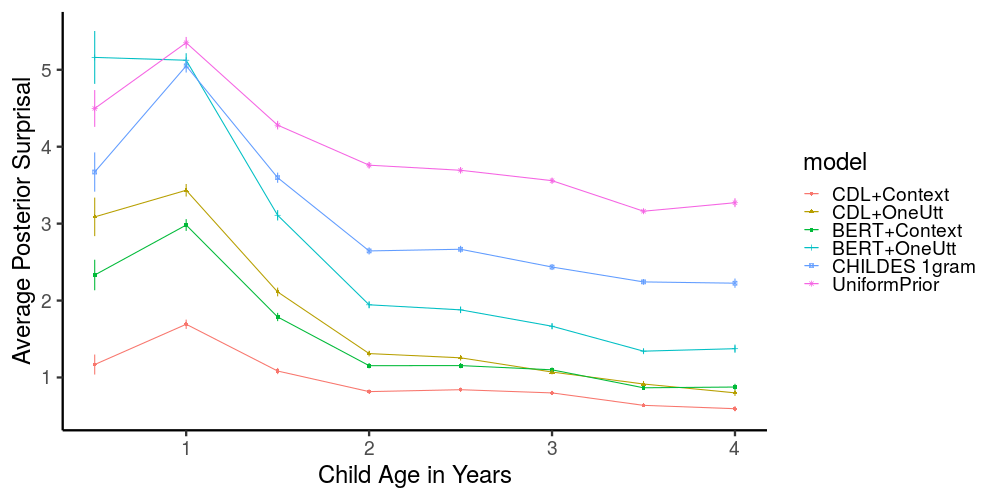

In [32]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [33]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,5.348551,0.201515
2,0.5,BERT+OneUtt,9.231796,0.396100
3,0.5,CDL+Context,1.997437,0.171230
4,0.5,CDL+OneUtt,4.846468,0.250880
5,0.5,CHILDES 1gram,9.047851,0.096144
6,0.5,UniformPrior,12.948367,0.000000
7,1.5,BERT+Context,5.442125,0.092561
8,1.5,BERT+OneUtt,8.902895,0.099959
9,1.5,CDL+Context,3.659360,0.079845
10,1.5,CDL+OneUtt,6.351280,0.086635


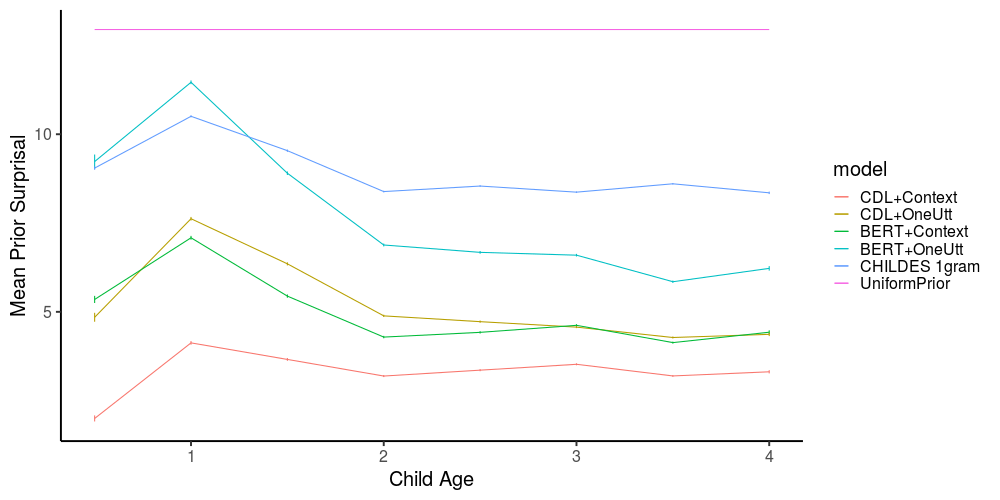

In [34]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [35]:
scores_across_time_short.set.value_counts()

success    89004
failure    33552
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [36]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,3.140217,0.082138
2,0.5,BERT+Context,success,1.321636,0.099834
3,0.5,BERT+OneUtt,failure,3.422165,0.078621
4,0.5,BERT+OneUtt,success,1.768993,0.111791
5,0.5,CDL+Context,failure,2.774801,0.090052
...,...,...,...,...,...
92,4.0,CDL+OneUtt,success,0.796633,0.032569
93,4.0,CHILDES 1gram,failure,2.840448,0.224749
94,4.0,CHILDES 1gram,success,2.070309,0.036971
95,4.0,UniformPrior,failure,5.122522,0.232140


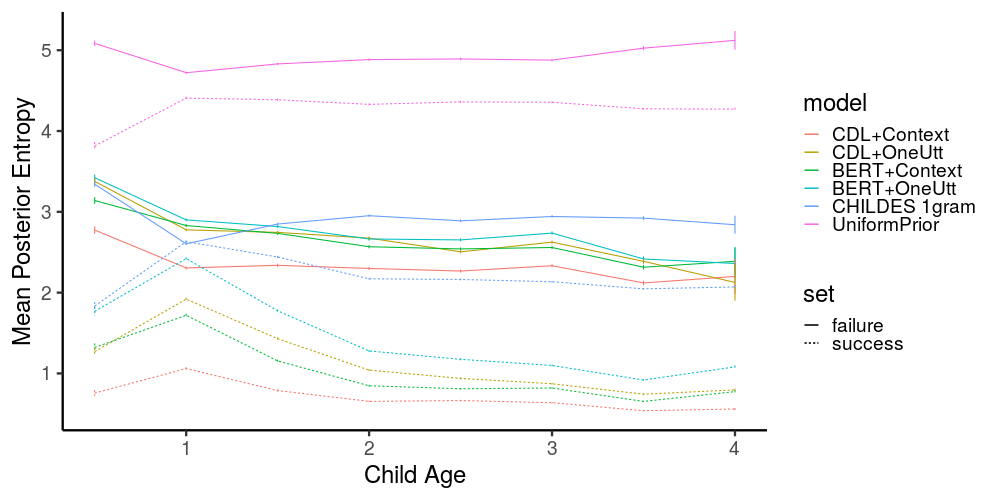

In [37]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [38]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [39]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age         model      gain   gain_sem comparison age_in_months
1 0.5  BERT+Context 18.401402 0.33068568  posterior             6
2 0.5   BERT+OneUtt 19.458719 0.62006432  posterior             6
3 0.5   CDL+Context 25.141474 0.53139612  posterior             6
4 0.5    CDL+OneUtt 23.826021 0.72296721  posterior             6
5 0.5 CHILDES 1gram 17.518088 0.16754666  posterior             6
6 0.5  UniformPrior  9.104747 0.09739289  posterior             6


In [40]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain   gain_sem comparison age_in_months
6  0.5 UniformPrior 9.104747 0.09739289  posterior             6
12 1.5 UniformPrior 8.730274 0.04224507  posterior            18
18 1.0 UniformPrior 8.478009 0.04514851  posterior            12
24 2.5 UniformPrior 8.897544 0.03091987  posterior            30
30 2.0 UniformPrior 8.918204 0.03177128  posterior            24
36 3.5 UniformPrior 9.014511 0.02860235  posterior            42
42 3.0 UniformPrior 8.984787 0.03107766  posterior            36
48 4.0 UniformPrior 9.124695 0.05074393  posterior            48


In [41]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [42]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

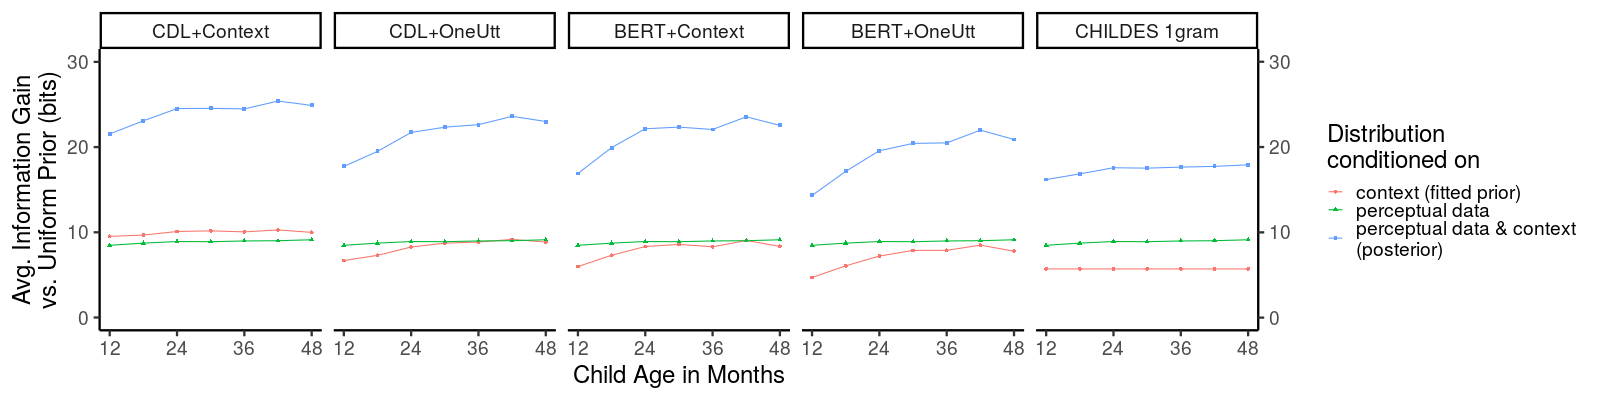

In [55]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

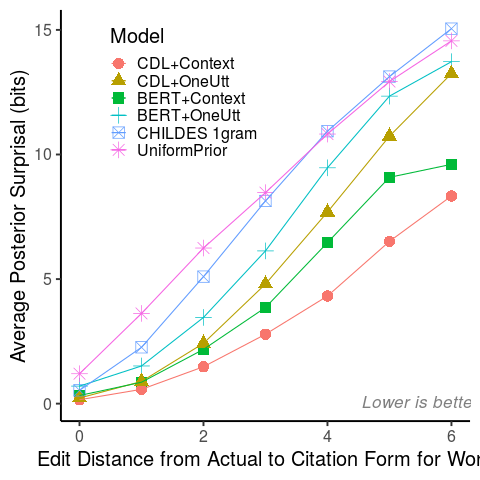

In [44]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [45]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance         model mean_posterior_surprisal
1              0  BERT+Context                0.3275929
2              0   BERT+OneUtt                0.7038308
3              0   CDL+Context                0.1581777
4              0    CDL+OneUtt                0.2267539
5              0 CHILDES 1gram                0.5345955
6              0  UniformPrior                1.2009314
7              1  BERT+Context                0.8604090
8              1   BERT+OneUtt                1.5129069
9              1   CDL+Context                0.5753985
10             1    CDL+OneUtt                0.8908206
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.011940114 0.3275929 0.3275929           1.200931
2                   0.017576842 0.7038308 0.7038308           1.200931
3                   0.006994938 0.1581777 0.1581777           1.200931
4                   0.008331978 0.2267539 0.2267539           1.200931
5                   0.0108344

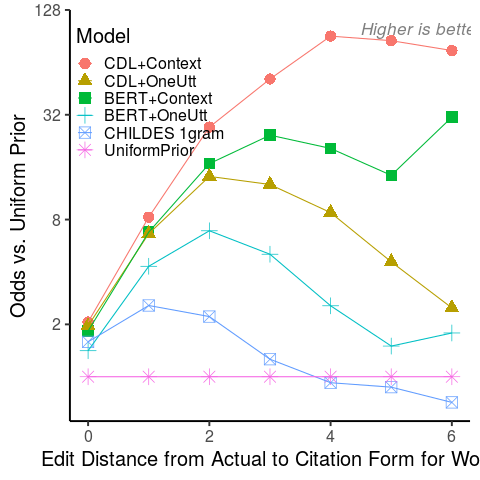

In [46]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

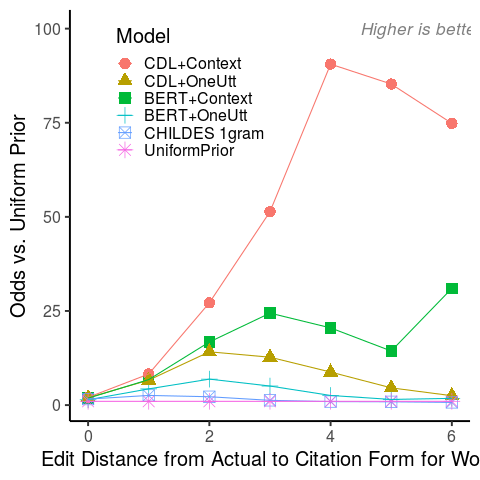

In [47]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [48]:
%%R
library(plotROC)

In [49]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 89004 33552


In [50]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "BERT+OneUtt"   "BERT+Context"  "CDL+OneUtt"    "CDL+Context"  
[5] "UniformPrior"  "CHILDES 1gram"


In [51]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [52]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [53]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [3] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [5] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [7] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [9] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"


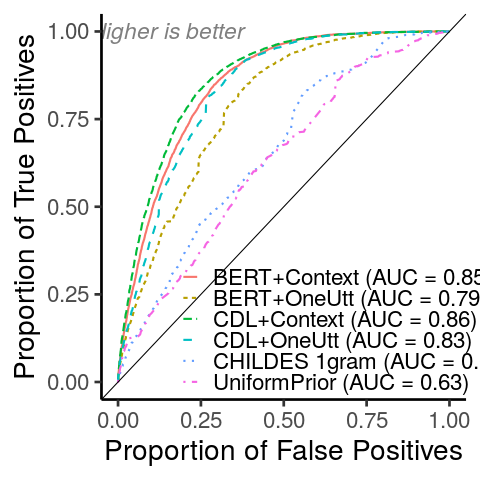

In [54]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    